# 项目介绍
https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/discussion
- 让你的司机走最短的路程。最短的时间就是我们所说的时间。如果a路线比B路线长X公里，但是比B路线快Y分钟，那就选择那条路线。

- 为了知道哪条路线是最好的选择，我们需要能够预测在走一条特定路线时旅程将持续多长时间。
- 因此，*本次目标是预测测试数据集中每次出行的持续时间，给定开始和结束坐标
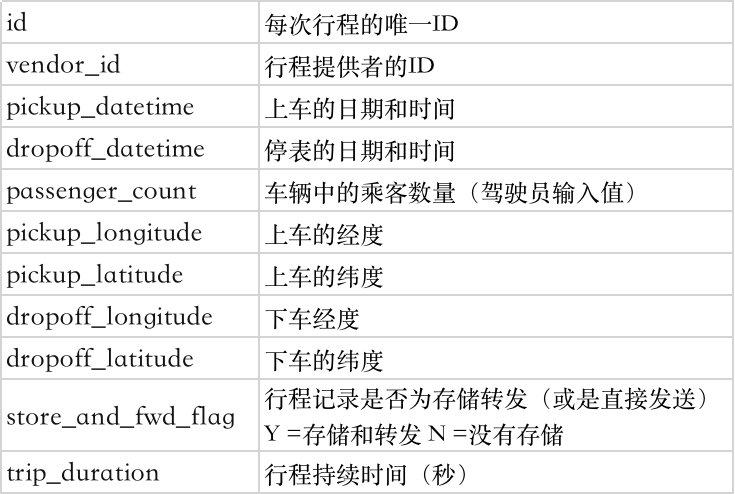

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from datetime import datetime, date
from sklearn .model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 30]
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
import dateutil.parser as parser



In [7]:
test_df = pd.read_csv(r'/Users/qi/kaggle/newyork_tax_time_data/test.csv')
train_df = pd.read_csv(r'/Users/qi/kaggle/newyork_tax_time_data/train.csv')

In [5]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [16]:
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
print('train shape:', train_df.shape)
print('test shape:', test_df.shape)

train shape: (1458644, 11)
test shape: (625134, 9)


In [8]:
# 测试集的特征比训练集少两个
# 查看缺少的特征是什么
list(set(train_df.columns) - set(test_df.columns))
# [i for i in train_df.columns if i not in test_df.columns]
# ['dropoff_datetime', 'trip_duration'] -- 行程结束时间和行程用时，是需要预测的

['dropoff_datetime', 'trip_duration']

In [3]:
# set_option设置显示数据
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.set_option.html "Pandas set_option
pd.set_option('display.float_format', lambda x: '%.3f' % x) 
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [8]:
# 上面的信息反映了什么？
# trip_duration最少1秒，最多3 526 282秒(大约980小时)。不可能有人旅行那么久，账单会是天文数字。
# 需要做异常值处理：排除2个标准差之外的数据
m = np.mean(train_df['trip_duration'])
s = np.std(train_df['trip_duration'])
train_df = train_df[(train_df['trip_duration']>=m - 2*s) & (train_df['trip_duration']<=m + 2*s)]
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1456564.000,1456564.000,1456564.000,1456564.000,1456564.000,1456564.000,1456564.000
mean,1.534,1.664,-73.973,40.751,-73.973,40.752,837.050
std,0.499,1.314,0.071,0.033,0.071,0.036,660.636
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1073.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,14040.000


In [11]:
train_df.shape

(1456564, 11)

In [12]:
# 纽约市经度[-74.03,-73.77]，纬度[40.63,40.85]
# 过滤掉不是纽约市的行程样本
xlim=[-74.03,-73.77]
ylim=[40.63,40.85]
train_df = train_df[(train_df['pickup_longitude']>=xlim[0]) & (train_df['pickup_longitude']<=xlim[1])]
train_df = train_df[(train_df['dropoff_longitude']>=xlim[0]) & (train_df['dropoff_longitude']<=xlim[1])]
train_df = train_df[(train_df['pickup_latitude']>=ylim[0]) & (train_df['pickup_latitude']<=ylim[1])]
train_df = train_df[(train_df['dropoff_latitude']>=ylim[0]) & (train_df['dropoff_latitude']<=ylim[1])]

print(train_df.shape[0])

1436596


In [54]:
train_df['pickup_datetime'].head()

0   2016-03-14 17:24:55
1   2016-06-12 00:43:35
2   2016-01-19 11:35:24
3   2016-04-06 19:32:31
4   2016-03-26 13:30:55
Name: pickup_datetime, dtype: datetime64[ns]

In [13]:
train_df['pickup_datetime'] = train_df['pickup_datetime'].apply(lambda x: parser.parse(str(x)))
test_df['pickup_datetime'] = test_df['pickup_datetime'].apply(lambda x: parser.parse(str(x)))
for df in (train_df, test_df):
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['hour'] = df['pickup_datetime'].dt.hour
    df['minute'] = df['pickup_datetime'].dt.minute
#     df['year'] = list(map(lambda x: x.year, df['pickup_datetime']))
#     df['month'] = list(map(lambda x: x.month, df['pickup_datetime']))
#     df['day'] = list(map(lambda x: x.day, df['pickup_datetime']))
#     df['hour'] = list(map(lambda x: x.hour, df['pickup_datetime']))
#     df['minute'] = list(map(lambda x: x.minute, df['pickup_datetime'])) 
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

In [99]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hour,minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,2016,3,14,17,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,2016,6,12,0,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,2016,1,19,11,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,2016,4,6,19,32
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,2016,3,26,13,30


In [100]:
train_df.shape

(1436612, 16)

In [14]:
# 1. date.weekday()：返回[0-6]，如果是星期一，返回0；如果是星期2，返回1，以此类推；
# 2. data.isoweekday()：返回[1-7]，如果是星期一，返回1；如果是星期2，返回2，以此类推

f = lambda x,y,z: 1 if date(x, y, z).isoweekday() in (6, 7) else 0
train_df['is_weekend'] = [f(x,y,z) for x,y,z in zip(train_df['year'],train_df['month'],train_df['day'])]
test_df['is_weekend'] = [f(x,y,z) for x,y,z in zip(test_df['year'],test_df['month'],test_df['day'])]

In [124]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hour,minute,is_weekend
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,2016,3,14,17,24,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,2016,6,12,0,43,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,2016,1,19,11,35,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,2016,4,6,19,32,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,2016,3,26,13,30,1


In [127]:
# i = 0
for a in zip([1,1,1],[2,2,2],[3,3,3]):
#     print(i)
    print(a)
#     i += 1
#     print(i)
print('*****')
for a in ([1,1,1],[2,2,2],[3,3,3]):
    print(a)

(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
*****
[1, 1, 1]
[2, 2, 2]
[3, 3, 3]


In [15]:
# 简化时间信息
train_df['pickup_time'] = train_df.hour + train_df.minute/60
test_df['pickup_time'] = test_df.hour + test_df.minute/60

In [16]:
# 分割早晚高峰rush hour、白天day和夜晚night
# [7,9] & [16, 18] - 早晚高峰
# (7,18) - day
# [0,7) | (18, 23] - night

for df in (train_df, test_df):
    df['hr_categori'] = np.nan
    df.loc[(df.hour <= 9) & (df.hour >= 7), 'hr_categori'] = 'rush'
    df.loc[(df.hour <= 18) & (df.hour >= 16), 'hr_categori'] = 'rush'
#     df.loc[(df.hour < 16) & (df.hour > 9), 'hr_categori'] = 'day'
#     df.loc[(df.hour < 7) | (df.hour > 18), 'hr_categori'] = 'night'
    df.loc[(df.hour < 18) & (df.hour > 7), 'hr_categori'] = 'day'
    df.loc[(df.hour <= 7) | (df.hour >= 18), 'hr_categori'] = 'night'

In [17]:
print('train shape:', train_df.shape)
print('test shape:', test_df.shape)

train shape: (1436596, 19)
test shape: (625134, 17)


In [18]:
train_df = train_df.assign(log_trip_duration = np.log(train_df.trip_duration + 1))

In [15]:
[i for i in train_df.columns if i not in test_df.columns]

['dropoff_datetime', 'trip_duration', 'log_trip_duration']

In [19]:
# 补充一些信息：
# 数据中包含了车程的总距离，花费的时间以及遇到了路口和具体的转向，由于数据集较大，数据分为两部分，
# 因为需要先把数据加载后合并（两个表的合并属于横向连接，使用pd.concat的方法）

fastrout1 = pd.read_csv(r'/Users/qi/kaggle/newyork_tax_time_data/fastest_routes_train_part_1.csv',
                        usecols=['id', 'total_distance', 'total_travel_time', 
                                 'number_of_steps','step_direction'])
fastrout2 = pd.read_csv(r'/Users/qi/kaggle/newyork_tax_time_data/fastest_routes_train_part_2.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  
                                 'number_of_steps','step_direction'])
fastrout = pd.concat((fastrout1,fastrout2))

In [71]:
fastrout.head()

,id,total_distance,total_travel_time,number_of_steps,step_direction
0,id2875421,2009.100,164.900,5,left|straight|right|straight|arrive
1,id2377394,2513.200,332.000,6,none|right|left|right|left|arrive
2,id3504673,1779.400,235.800,4,left|left|right|arrive
3,id2181028,1614.900,140.100,5,right|left|right|left|arrive
4,id0801584,1393.500,189.400,5,right|right|right|left|arrive


In [73]:
fastrout.shape

(1458643, 5)

In [20]:
# 这里可以把right和left的数据单独提取出来，注意里面还存在slight right和slight left，
# 这种是需要去掉的，这里的处理和之前添加年份的字段处理类似，
# 都是对于某一字段中数据提取，可以使用map()方法，也可以使用apply进阶方式
right_turn = list(map(lambda x:x.count('right')-x.count('slight right'),fastrout.step_direction))
left_turn = list(map(lambda x:x.count('left')-x.count('slight left'),fastrout.step_direction))
#这两种方法选择一种即可
#right_turn = fastrout['step_direction'].apply(lambda x:x.count('right')-x.count('slight right'))
#left_turn = fastrout['step_direction'].apply(lambda x:x.count('left')-x.count('slight left'))

In [ ]:
# 然后将这两个字段数据添加到原来的数据中，代替step_direction字段的数据，
# 关于添加字段的方法也是有两种，之前一直使用的是df[‘字段名’] = data， 
# 也可以使用pd.assign(data = data)的方式

osrm_data = fastrout[['id','total_distance','total_travel_time','number_of_steps']]
osrm_data = osrm_data.assign(right_steps=right_turn)
osrm_data = osrm_data.assign(left_steps=left_turn)
#或者使用以往的方法
#osrm_data['right_steps'] = right_turn
#osrm_data['left_steps'] = left_turn
osrm_data.head()

In [21]:
right_turn = list(map(lambda x:x.count('right')-x.count('slight right'),fastrout.step_direction))
left_turn = list(map(lambda x:x.count('left')-x.count('slight left'),fastrout.step_direction))
osrm_data = fastrout[['id','total_distance','total_travel_time','number_of_steps']]
osrm_data = osrm_data.assign(right_steps=right_turn)
osrm_data = osrm_data.assign(left_steps=left_turn)
osrm_data.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2009.100,164.900,5,1,1
1,id2377394,2513.200,332.000,6,2,2
2,id3504673,1779.400,235.800,4,1,2
3,id2181028,1614.900,140.100,5,2,2
4,id0801584,1393.500,189.400,5,3,1


In [26]:
# 同样的方式处理测试数据集
fastrout_test = pd.read_csv(r'/Users/qi/kaggle/newyork_tax_time_data/fastest_routes_test.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
test_right_turn = list(map(lambda x:x.count('right') - x.count('slight right'), fastrout_test.step_direction))
test_left_turn = list(map(lambda x:x.count('left') - x.count('slight left'), fastrout_test.step_direction))

osrm_test = fastrout_test[['id','total_distance','total_travel_time','number_of_steps']]
osrm_test = osrm_test.assign(right_steps=test_right_turn)
osrm_test = osrm_test.assign(left_steps=test_left_turn)

osrm_test.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.100,200.200,7,2,3
1,id3274209,1427.100,141.500,2,0,0
2,id2756455,2312.300,324.600,9,4,4
3,id3684027,931.800,84.200,4,2,1
4,id3101285,2501.700,294.700,8,3,3


In [22]:
# 计算速度
coords = np.vstack((train_df[['pickup_longitude', 'pickup_latitude']].values,
                   train_df[['dropoff_longitude', 'dropoff_latitude']].values,
                   test_df[['pickup_longitude', 'pickup_latitude']].values,
                   test_df[['dropoff_longitude', 'dropoff_latitude']].values))

coords

array([[-73.98215485,  40.76793671],
       [-73.98041534,  40.73856354],
       [-73.97902679,  40.7639389 ],
       ...,
       [-73.87660217,  40.74866486],
       [-73.85426331,  40.89178848],
       [-73.96932983,  40.76937866]])

In [142]:
coords.shape

(4123492, 2)

In [23]:
# 对位置进行聚类，指定8个类
# kmeans = MiniBatchKMeans(n_clusters = 8, batch_size = 10000).fit(coords)

In [24]:
# 对位置进行聚类，指定8个类
kmeans = MiniBatchKMeans(n_clusters = 8, batch_size = 10000).fit(coords)
# 为样本中每个簇打标
train_df.loc[:, 'pickup_cluster'] = kmeans.predict(train_df[['pickup_longitude', 'pickup_latitude']])
# 上面写法同此种：train_df['pickup_cluster'] = kmeans.predict(train_df[['pickup_longitude', 'pickup_latitude']])
train_df.loc[:, 'dropoff_cluster'] = kmeans.predict(train_df[['dropoff_longitude', 'dropoff_latitude']])
test_df.loc[:, 'pickup_cluster'] = kmeans.predict(test_df[['pickup_longitude', 'pickup_latitude']])
test_df.loc[:, 'dropoff_cluster'] = kmeans.predict(test_df[['dropoff_longitude', 'dropoff_latitude']])

train_df[['pickup_longitude', 'pickup_latitude', 
       'dropoff_longitude', 'dropoff_latitude', 
       'pickup_cluster', 'dropoff_cluster']].head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_cluster,dropoff_cluster
0,-73.982,40.768,-73.965,40.766,5,5
1,-73.980,40.739,-73.999,40.731,7,7
2,-73.979,40.764,-74.005,40.710,5,1
3,-74.010,40.720,-74.012,40.707,1,1
4,-73.973,40.793,-73.973,40.783,0,5


In [1]:
xlim=[-74.03,-73.77]
ylim=[40.63,40.85]
plt.figure(figsize = (10, 8))
loc_df_1 = pd.DataFrame(coords, columns=['longitude', 'latitude'])
loc_df_1['label']=kmeans.labels_
for label in np.unique(kmeans.labels_):
    plt.plot(loc_df_1.longitude[loc_df_1.label == label], loc_df_1.latitude[loc_df_1.label == label],
            '.', markersize = 0.5, alpha = 0.5)
    plt.xlim(xlim)
    plt.ylim(ylim)

NameError: name 'plt' is not defined

In [29]:
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'year', 'month', 'day', 'hour', 'minute', 'is_weekend',
       'pickup_time', 'hr_categori', 'log_trip_duration', 'pickup_cluster',
       'dropoff_cluster', 'total_distance', 'total_travel_time',
       'number_of_steps', 'right_steps', 'left_steps'],
      dtype='object')

In [31]:
train_df = train_df.join(osrm_data.set_index('id'), on = 'id')
test_df = test_df.join(osrm_test.set_index('id'), on = 'id')

print('train_join shape:', train_df.shape)
print('test_join shape:', test_df.shape)

train_join shape: (1436596, 27)
test_join shape: (625134, 24)


In [32]:
# 统计上车和下车地对应每个簇（8个）的样本数
a = pd.concat([train_df, test_df]).groupby(['pickup_cluster']).size().reset_index()
b = pd.concat([train_df, test_df]).groupby(['dropoff_cluster']).size().reset_index()

In [28]:
a

,pickup_cluster,0
0,0,500324
1,1,58461
2,2,142896
3,3,368767
4,4,44273
5,5,602098
6,6,310862
7,7,34065


In [33]:
train_df = pd.merge(train_df, a, on = 'pickup_cluster', how = 'left')
train_df = pd.merge(train_df, b, on = 'dropoff_cluster', how = 'left')

test_df = pd.merge(test_df, a, on = 'pickup_cluster', how = 'left')
test_df = pd.merge(test_df, b, on = 'dropoff_cluster', how = 'left')

In [34]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,pickup_cluster,dropoff_cluster,total_distance,total_travel_time,number_of_steps,right_steps,left_steps,0_x,0_y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,...,6.122,5,5,2009.100,164.900,5.000,1.000,1.000,585703,558236
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,...,6.498,7,7,2513.200,332.000,6.000,2.000,2.000,318434,295686
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,...,7.662,5,1,11060.800,767.600,16.000,5.000,4.000,585703,229647
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,...,6.064,1,1,1779.400,235.800,4.000,1.000,2.000,233373,229647
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,...,6.078,0,5,1614.900,140.100,5.000,2.000,2.000,275897,558236


In [35]:
train_df['speed'] = train_df['total_distance'] / train_df['trip_duration']
train_df[['speed', 'total_distance', 'trip_duration']].head()

,speed,total_distance,trip_duration
0,4.416,2009.100,455
1,3.791,2513.200,663
2,5.208,11060.800,2124
3,4.148,1779.400,429
4,3.712,1614.900,435


In [36]:
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'year', 'month', 'day', 'hour', 'minute', 'is_weekend',
       'pickup_time', 'hr_categori', 'log_trip_duration', 'pickup_cluster',
       'dropoff_cluster', 'total_distance', 'total_travel_time',
       'number_of_steps', 'right_steps', 'left_steps', '0_x', '0_y', 'speed'],
      dtype='object')

In [37]:
print('train_join shape:', train_df.shape)
print('test_join shape:', test_df.shape)

train_join shape: (1436596, 30)
test_join shape: (625134, 26)


In [38]:
[i for i in train_df.columns if i not in test_df.columns]

['dropoff_datetime', 'trip_duration', 'log_trip_duration', 'speed']

In [39]:
pickup_speed = train_df[['speed', 'pickup_cluster']].groupby('pickup_cluster').mean().reset_index()
pickup_speed = pickup_speed.rename(columns = {'speed' : 'ave_pickup_speed'})

dropoff_speed = train_df[['speed', 'dropoff_cluster']].groupby('dropoff_cluster').mean().reset_index()
dropoff_speed = dropoff_speed.rename(columns = {'speed' : 'ave_dropoff_speed'})

In [40]:
print(pickup_speed)
print(dropoff_speed)

   pickup_cluster  ave_pickup_speed
0               0             5.600
1               1             5.272
2               2            11.207
3               3             4.972
4               4             8.285
5               5             5.017
6               6             6.097
7               7             4.943
   dropoff_cluster  ave_dropoff_speed
0                0              6.241
1                1              5.239
2                2             12.113
3                3              4.607
4                4              8.361
5                5              4.881
6                6              6.731
7                7              4.904


In [41]:
train_df = pd.merge(train_df, pickup_speed, on = 'pickup_cluster', how = 'left')
train_df = pd.merge(train_df, dropoff_speed, on = 'dropoff_cluster', how = 'left')

test_df = pd.merge(test_df, pickup_speed, on = 'pickup_cluster', how = 'left')
test_df = pd.merge(test_df, dropoff_speed, on = 'dropoff_cluster', how = 'left')


In [44]:
train_df = train_df.drop('speed', axis = 1)

In [46]:
print('train shape:', train_df.shape)
print('test shape:', test_df.shape)

train shape: (1436596, 31)
test shape: (625134, 28)


In [47]:
# Dummy variables: One-hot encode 处理所有类型特征
# 类型特征用数字标记，但数字间的大小关系会对预测产生我们不希望的影响
vendor_train = pd.get_dummies(train_df['vendor_id'], prefix = 'vi', prefix_sep = '_')
pickup_cluster_train = pd.get_dummies(train_df['pickup_cluster'], prefix = 'p', prefix_sep = '_')
dropoff_cluster_train = pd.get_dummies(train_df['dropoff_cluster'], prefix = 'd', prefix_sep = '_')
store_fwd_flag_train = pd.get_dummies(train_df['store_and_fwd_flag'], prefix = 's', prefix_sep = '_')

vendor_test = pd.get_dummies(test_df['vendor_id'], prefix = 'vi', prefix_sep = '_')
pickup_cluster_test = pd.get_dummies(test_df['pickup_cluster'], prefix = 'p', prefix_sep = '_')
dropoff_cluster_test = pd.get_dummies(test_df['dropoff_cluster'], prefix = 'd', prefix_sep = '_')
store_fwd_flag_test = pd.get_dummies(test_df['store_and_fwd_flag'], prefix = 's', prefix_sep = '_')

train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek
test_df['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek

month_train = pd.get_dummies(train_df['month'], prefix = 'm', prefix_sep = '_')
dam_train = pd.get_dummies(train_df['day'], prefix = 'dam', prefix_sep = '_')
daw_train = pd.get_dummies(train_df['dayofweek'], prefix = 'daw', prefix_sep = '_')
hr_train = pd.get_dummies(train_df['hour'], prefix = 'h', prefix_sep = '_')
hr_cate_train = pd.get_dummies(train_df['hr_categori'], prefix = 'hc', prefix_sep = '_')

month_test = pd.get_dummies(test_df['month'], prefix = 'm', prefix_sep = '_')
dam_test = pd.get_dummies(test_df['day'], prefix = 'dam', prefix_sep = '_')
daw_test = pd.get_dummies(test_df['dayofweek'], prefix = 'daw', prefix_sep = '_')
hr_test = pd.get_dummies(test_df['hour'], prefix = 'h', prefix_sep = '_')
hr_cate_test = pd.get_dummies(test_df['hr_categori'], prefix = 'hc', prefix_sep = '_')

In [48]:
train_df = train_df.drop(['id', 'vendor_id', 'pickup_cluster', 'dropoff_cluster', 
                          'store_and_fwd_flag', 'month', 'day', 'dayofweek', 'hour', 
                          'hr_categori', 'dropoff_datetime', 'trip_duration'], axis = 1)
Test_id = test_df['id']
test_df = test_df.drop(['id', 'vendor_id', 'pickup_cluster', 'dropoff_cluster', 
                        'store_and_fwd_flag', 'month', 'day', 'dayofweek', 
                        'hour', 'hr_categori'], axis = 1)

In [49]:
Train_Master = pd.concat([train_df, vendor_train, pickup_cluster_train, dropoff_cluster_train, 
                          store_fwd_flag_train,month_train, dam_train, daw_train, hr_train,
                          hr_cate_train], axis = 1)
Test_Master = pd.concat([test_df, vendor_test, pickup_cluster_test, dropoff_cluster_test, 
                         store_fwd_flag_test, month_test, dam_test, daw_test, hr_test, 
                         hr_cate_test], axis = 1)

In [50]:
Train_Master = Train_Master.drop('pickup_datetime', axis = 1)
Test_Master = Test_Master.drop('pickup_datetime', axis = 1)

# 从训练集中拆分验证集
Train, Test = train_test_split(Train_Master, test_size = 0.01)

X_Train = Train.drop('log_trip_duration', axis = 1)
Y_Train = Train['log_trip_duration']
X_Test = Test.drop('log_trip_duration', axis = 1)
Y_Test = Test['log_trip_duration']

Y_Train = Y_Train.reset_index().drop('index', axis = 1)
Y_Test = Y_Test.reset_index().drop('index', axis = 1)

In [51]:
dtrain = xgb.DMatrix(X_Train, label = Y_Train)
dvalid = xgb.DMatrix(X_Test, label = Y_Test)
dtest = xgb.DMatrix(Test_Master)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# 理想的结果是模型在watchlist中的两个set上表现一样地好

In [52]:
xgb_pars = {'objective' : 'reg:linear',
           'learning_rate' : 0.05,
           'max_depth' : 7,
           'subsample' : 0.8,
           'colsample_bytree' : 0.7,
           'colsample_bylevel' : 0.7,
           'silent' : 1,
           'reg_alpha' : 1}

model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds = 5,
                 maximize = False, verbose_eval = 1)
print('Modeling RMSLE % .5f' %model.best_score)

[19:01:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:5.70039	valid-rmse:5.70021
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:5.41698	valid-rmse:5.41657
[2]	train-rmse:5.14778	valid-rmse:5.14719
[3]	train-rmse:4.89207	valid-rmse:4.89126
[4]	train-rmse:4.64935	valid-rmse:4.64834
[5]	train-rmse:4.41875	valid-rmse:4.41759
[6]	train-rmse:4.19983	valid-rmse:4.19843

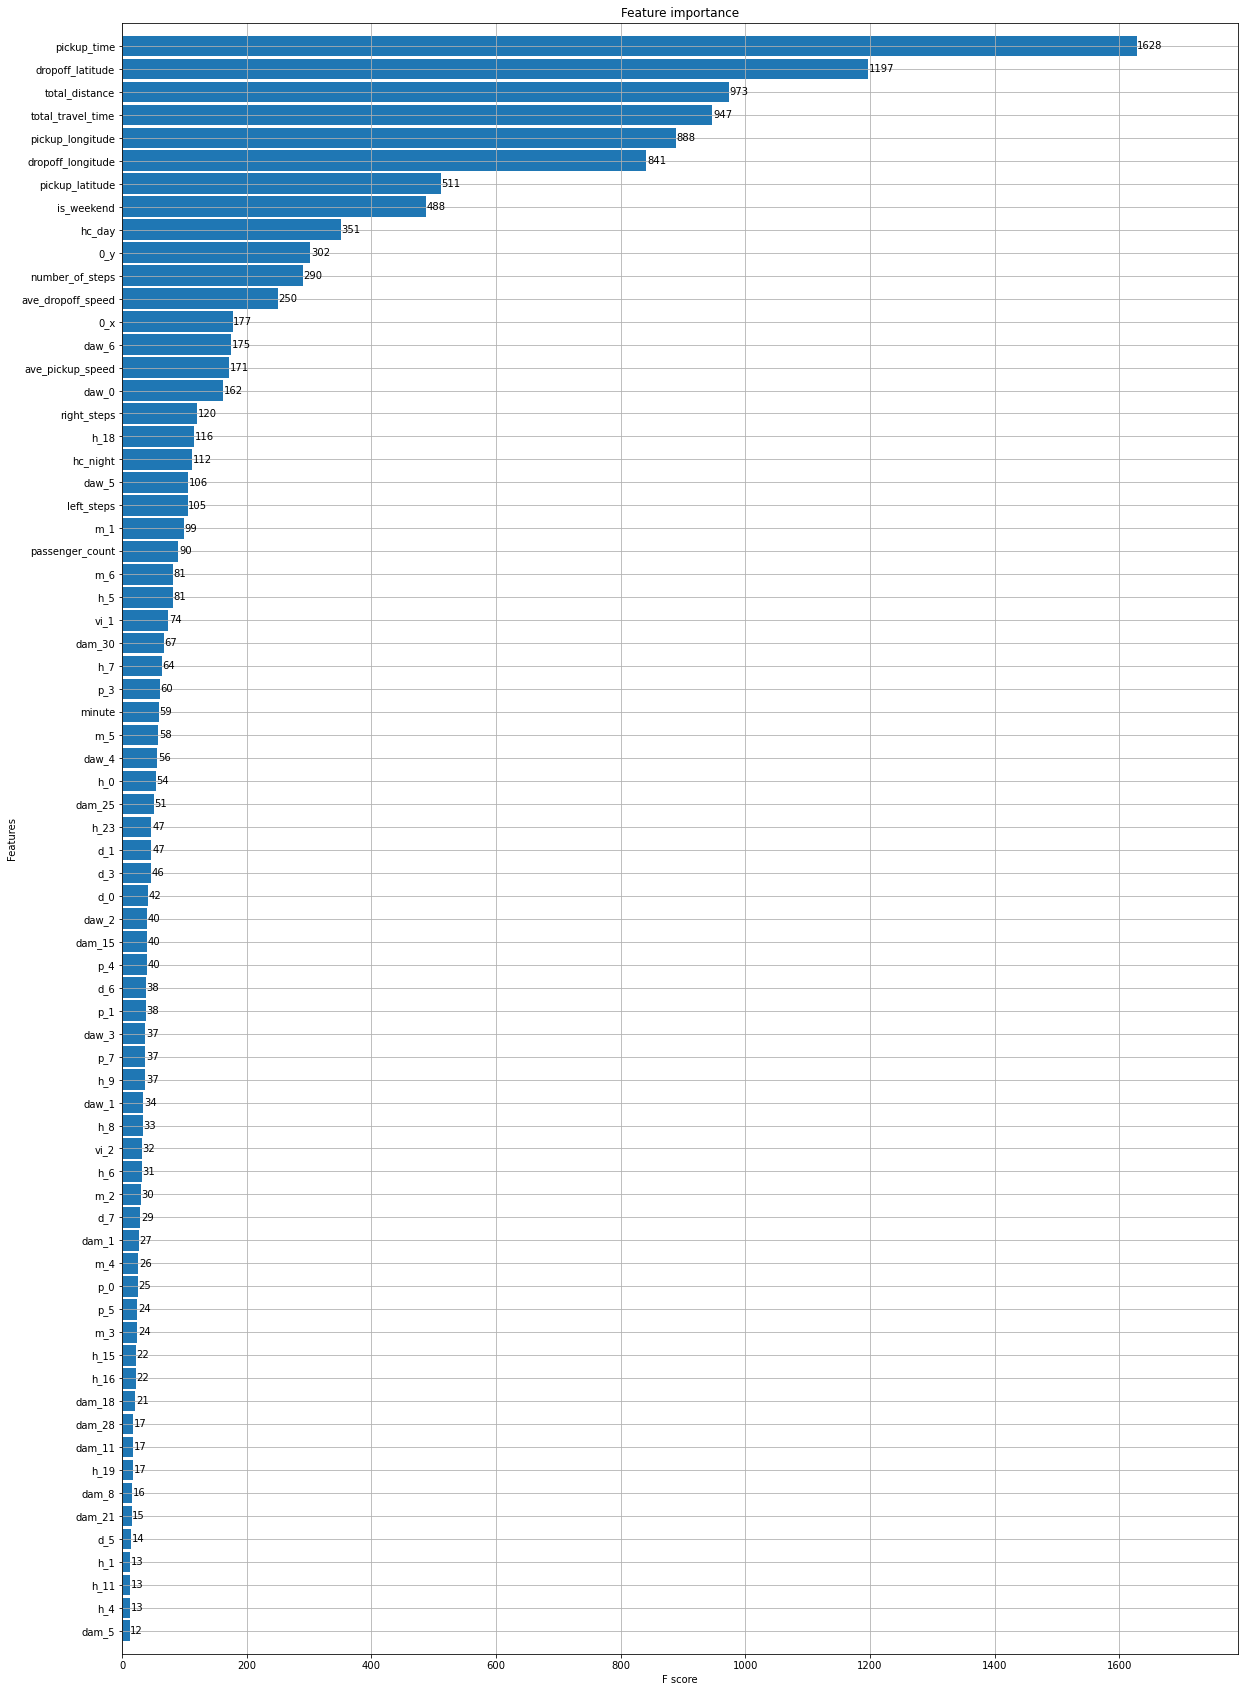

In [53]:
ax = xgb.plot_importance(model, max_num_features = 70, height = 0.9)
ax.figure.set_size_inches(20, 30)

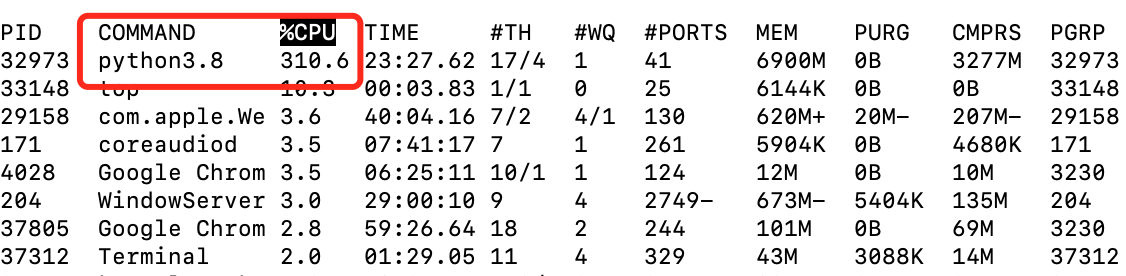

In [ ]:
# kaggle提交部分
pred = model.predict(dtest)
pred = np.exp(pred) - 1

submission = pd.concat([Test_id, pd.DataFrame(pred)], axis = 1)
submission.columns = ['id', 'trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv('submission.csv', index = False)

# 可视化部分

In [26]:
# 纽约市经度[-74.03,-73.77]，纬度[40.63,40.85]
# 过滤掉不是纽约市的行程样本
df = train_df
xlim=[-74.03,-73.77]
ylim=[40.63,40.85]
df=df[(df['pickup_longitude']>=xlim[0]) & (df['pickup_longitude']<=xlim[1])]
df=df[(df['dropoff_longitude']>=xlim[0]) & (df['dropoff_longitude']<=xlim[1])]
df=df[(df['pickup_latitude']>=ylim[0]) & (df['pickup_longitude']<=ylim[1])]
df=df[(df['dropoff_latitude']>=ylim[0]) & (df['dropoff_latitude']<=ylim[1])]
print(df.shape[0])

1437058


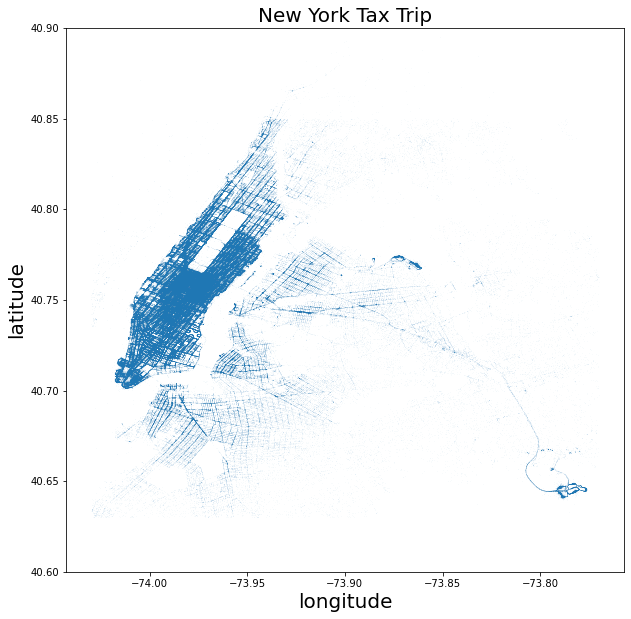

In [35]:
# 合并上下车经纬度数据，绘制出图像：
longitude=list(df['pickup_longitude'])+list(df['dropoff_longitude'])
latitude=list(df['pickup_latitude'])+list(df['dropoff_latitude'])
plt.figure(figsize=(10,10))
plt.plot(longitude, latitude, '.', alpha=0.4, markersize=0.05)
plt.title('New York Tax Trip', size=20)
plt.xlabel('longitude', size=20)
plt.ylabel('latitude', size=20)
plt.ylim([40.6,40.9])
# plt.axes([-74.03,-73.77,40.6,40.9])
plt.show()

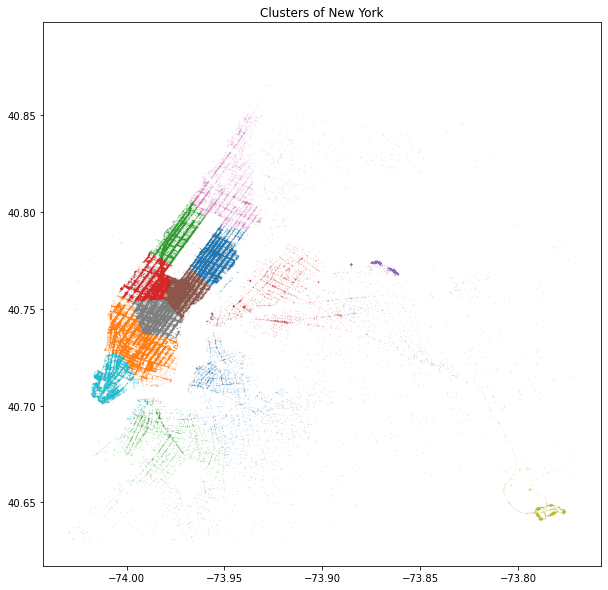

In [36]:
# 然后我们需要对图上客流量较为密集的几个区域进行划分，用聚类试试
loc_df=pd.DataFrame()  #提取经纬度数据
loc_df['longitude']=longitude
loc_df['latitude']=latitude
kmeans=KMeans(n_clusters=15,random_state=2,n_init=10).fit(loc_df)
loc_df['label']=kmeans.labels_
#聚类，分成15个簇，绘图，标记不同的颜色
loc_df=loc_df.sample(200000)
plt.figure(figsize=(10,10))
for label in loc_df.label.unique(): 
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.',alpha=0.3,markersize=0.3)
    
plt.title('Clusters of New York')
plt.show()


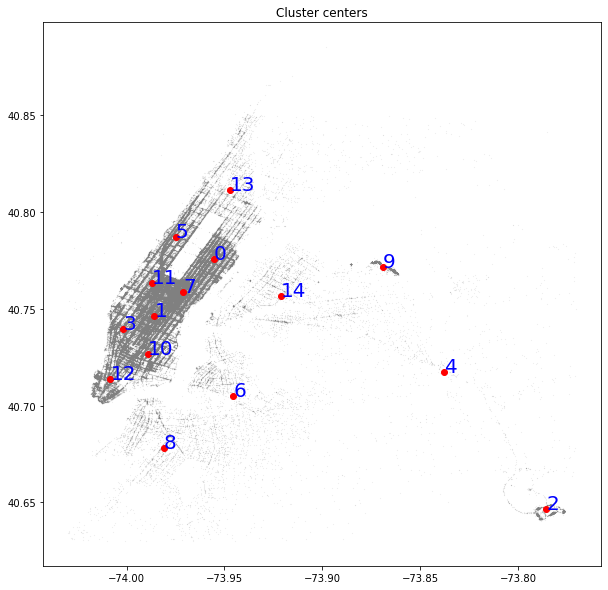

In [37]:
fig,ax=plt.subplots(figsize=(10,10))
for label in loc_df.label.unique():    #找到每个区域的中心点，给区域作个标记。
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.',alpha=0.3,markersize=0.3,color='gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster centers')
plt.show()

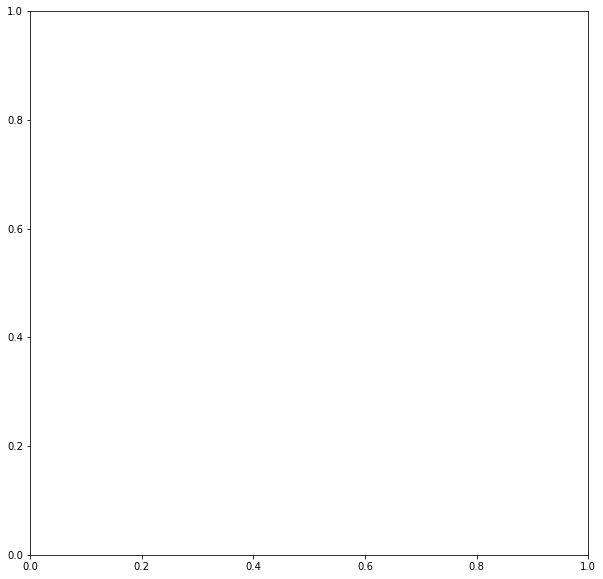

In [48]:
# 客流趋势动态展示
# 对各个区域之间客流趋向进行标记
import dateutil.parser as parser

#使用predict方法进行新数据类别的预测，将上车地点所在簇记为pickup_cluster
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])  
#将上车地点所在簇记为dropoff_cluste
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']]) 
#模块parser从字符串中解析出时间对象，上车时间记为pickuphour
df['pickup_hour']=df.pickup_datetime.apply(lambda x:parser.parse(x).hour)  

clusters=pd.DataFrame()
clusters['x']=kmeans.cluster_centers_[:,0]  #取出簇中心的横坐标、纵坐标
clusters['y']=kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))
loc_df = loc_df.sample(5000)

        

NameError: name 'init' is not defined

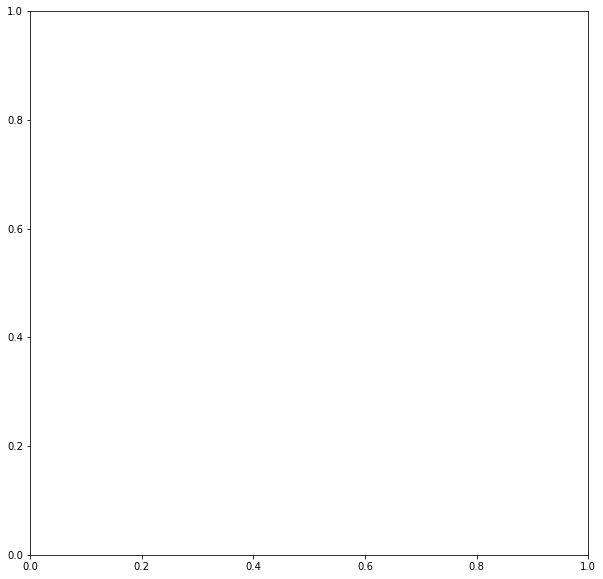

In [59]:
from matplotlib import animation 

# 展示客流的方向与趋势，箭头的宽度与车流量成正比

fig, ax = plt.subplots(1, 1, figsize = (10,10)) #创建一个1x1的子图，大小为10*10
#画出地图
def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    #设置标题
    plt.figure(figsize = (10,10))  
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        #画出每个簇中的地点的经度，纬度，小圆点，灰色
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
        #画出每个簇的中心的坐标，大圆点，红色
        
    #画客流方向 ，并以动画形式展示          
    for label in clusters.label:  #以每个簇为起始点
        for dest_label in clusters.label:  #每个簇为终点
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            #num_of_rides表示客流量，等于(所有时间段的)每个簇上车点数量+每个簇下车点数量.
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            #diet_x表示每个簇到其他簇的横坐标
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')
            
ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()),
                              interval = 1000, blit=True)
plt.close()
# plt.savefig('animation2', dpi=96)
ani.save('animation2.gif', writer='imagemagick', fps=2)
# plt.show()

In [54]:
!pwd

/Users/qi/algo/A-实战


In [ ]:
# 高峰时段的交通和周末与非周末的交通可能会对出行时间产生影响。
# 与此类似，在一年中的不同月份之间，旅行时间也可能存在季节性。
# 例如，想想纽约的冬季可能对旅行时间的影响。如果路上是湿的/结冰的，
# 你就不太可能开得很快，所以不管你走哪条路，你都要花更多的时间才能到达目的地。


In [9]:
accidents_df = pd.read_csv(r'/Users/qi/kaggle/newyork_tax_time_data/accidents_2016.csv')
accidents_df.head()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,datetime
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,NaN,NaN,NaN,3448403.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,2016-05-27 17:30:00
1,NaN,NaN,40.70044,-73.815332,"(40.7004397, -73.8153324)",NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,3423067.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,2016-04-27 09:04:00
2,QUEENS,11433.0,NaN,NaN,NaN,brewer boulevard,111th avenue,NaN,0.0,0.0,...,NaN,NaN,NaN,3458894.0,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,2016-06-09 11:30:00
3,QUEENS,11423.0,NaN,NaN,NaN,199th street,100th avenue,NaN,0.0,0.0,...,NaN,NaN,NaN,3459472.0,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,2016-06-07 22:06:00
4,QUEENS,11434.0,NaN,NaN,NaN,brewer boulevard,146th terrace,NaN,0.0,0.0,...,NaN,NaN,NaN,3458030.0,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,2016-06-07 22:06:00


In [10]:
accidents_df.columns

Index(['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5', 'datetime'],
      dtype='object')

MovieWriter imagemagick unavailable; trying to use pillow instead.


TypeError: 'str' object is not callable

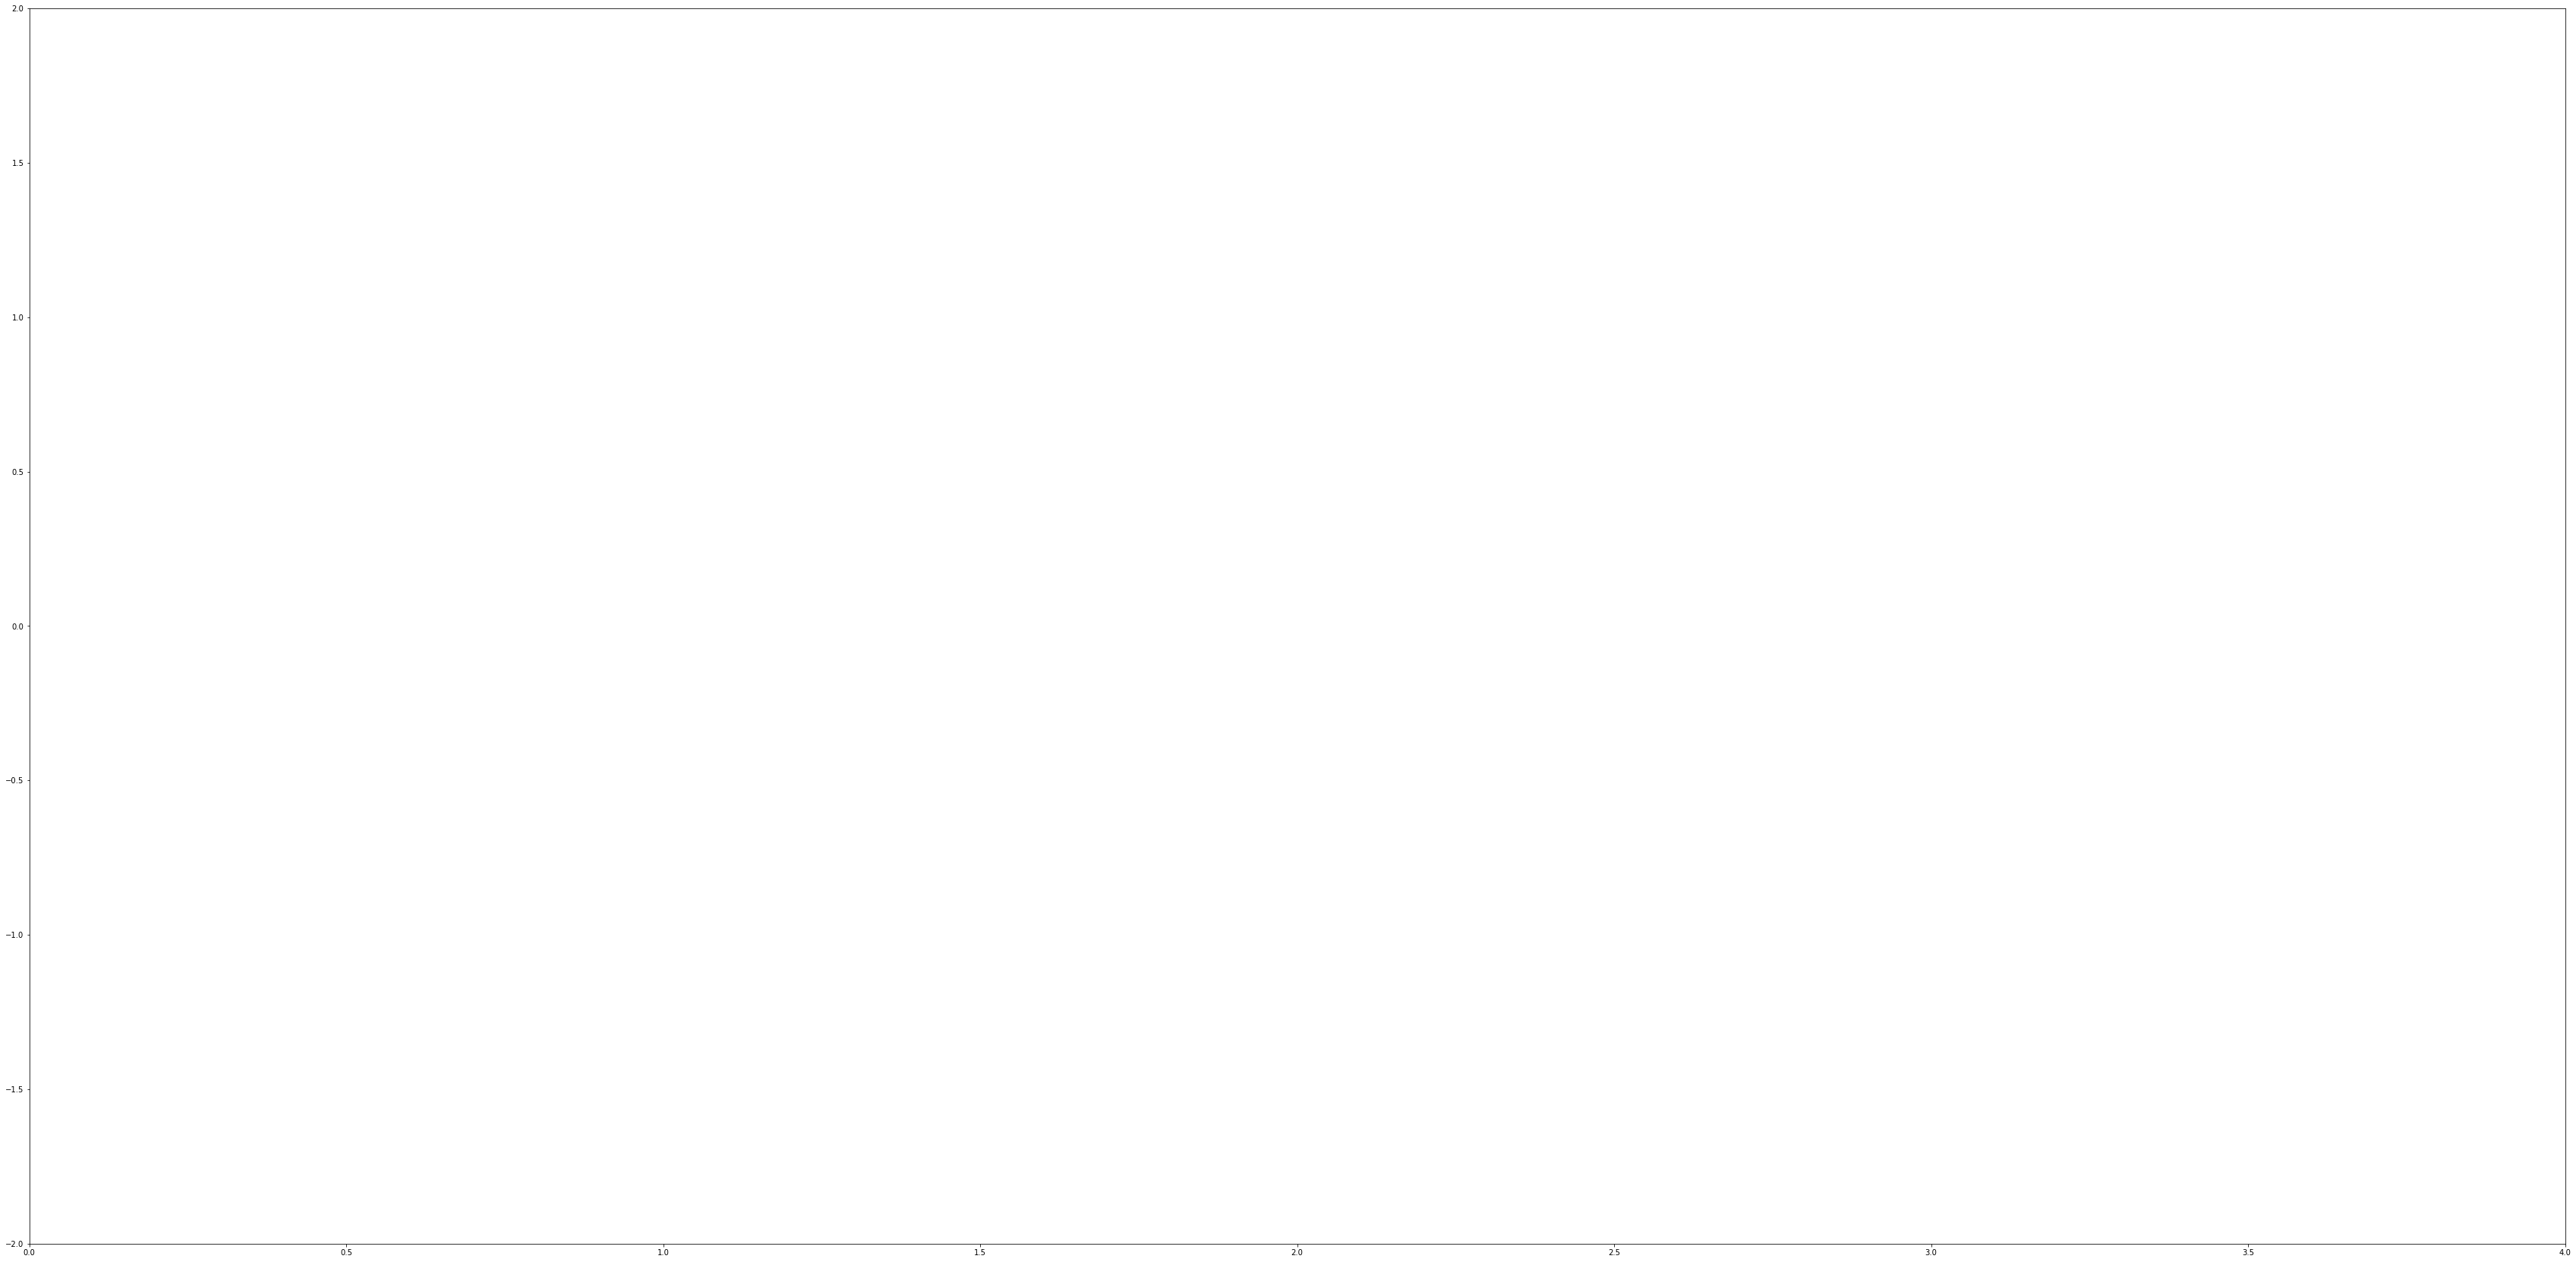

In [69]:
import numpy as np

from matplotlib import pyplot as plt

from matplotlib.animation import FuncAnimation,PillowWriter

plt.style.use('seaborn-pastel')

fig = plt.figure()

ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))

line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = np.linspace(0, 4, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,frames=200, interval=20, blit=True)

anim.save('sine_wave.gif', writer='imagemagick')
